In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

import pandas as pd
import numpy as np

from fastai.vision import *

import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as pip
%matplotlib inline
%reload_ext autoreload
%autoreload

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


## Read Dataset Files

In [5]:
base_dir = '/content/drive/MyDrive/네카라쿠배/딥러닝 프로젝트/dataset/fashion/padding_resize/train/2/19'
fnames = os.listdir(base_dir)

In [6]:
# 데이터가 너무 많아서 임시로 train, test 분리 / category 19만 사용

data_df = pd.DataFrame(columns=('images', 'category', 'dataset'))

for idx in range(300):
    images = fnames[idx]
    category = 19
    dataset = 'train'
    data_df = data_df.append(pd.DataFrame([[images, category, dataset]], columns=['images', 'category', 'dataset']), ignore_index=True)

for idx in range(300,len(fnames)):
    images = fnames[idx]
    category = 19
    dataset = 'test'
    data_df = data_df.append(pd.DataFrame([[images, category, dataset]], columns=['images', 'category', 'dataset']), ignore_index=True)

## prepare DataBunch

In [7]:
from pathlib import Path
images_path = Path('/content/drive/MyDrive/네카라쿠배/딥러닝 프로젝트/dataset/fashion/padding_resize/train/2/19')

In [8]:
images_path

PosixPath('/content/drive/MyDrive/네카라쿠배/딥러닝 프로젝트/dataset/fashion/padding_resize/train/2/19')

In [9]:
data_source = (ImageList.from_df(df=data_df, path=images_path, cols='images').split_by_idxs((data_df[data_df['dataset']=='train'].index), (data_df[data_df['dataset']=='val'].index)).label_from_df(cols='category'))

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [10]:
tmfs = get_transforms()

data = data_source.transform(tmfs, size=224).databunch(bs=128).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [11]:
test_data = ImageList.from_df(df=data_df[data_df['dataset'] == 'test'], path=images_path, cols='images')
data.add_test(test_data)

In [12]:
# To maintain the order of images in train data, turning off shuffle
# data.train_dl = data.train_dl = data.train_dl.new(shuffle=False)

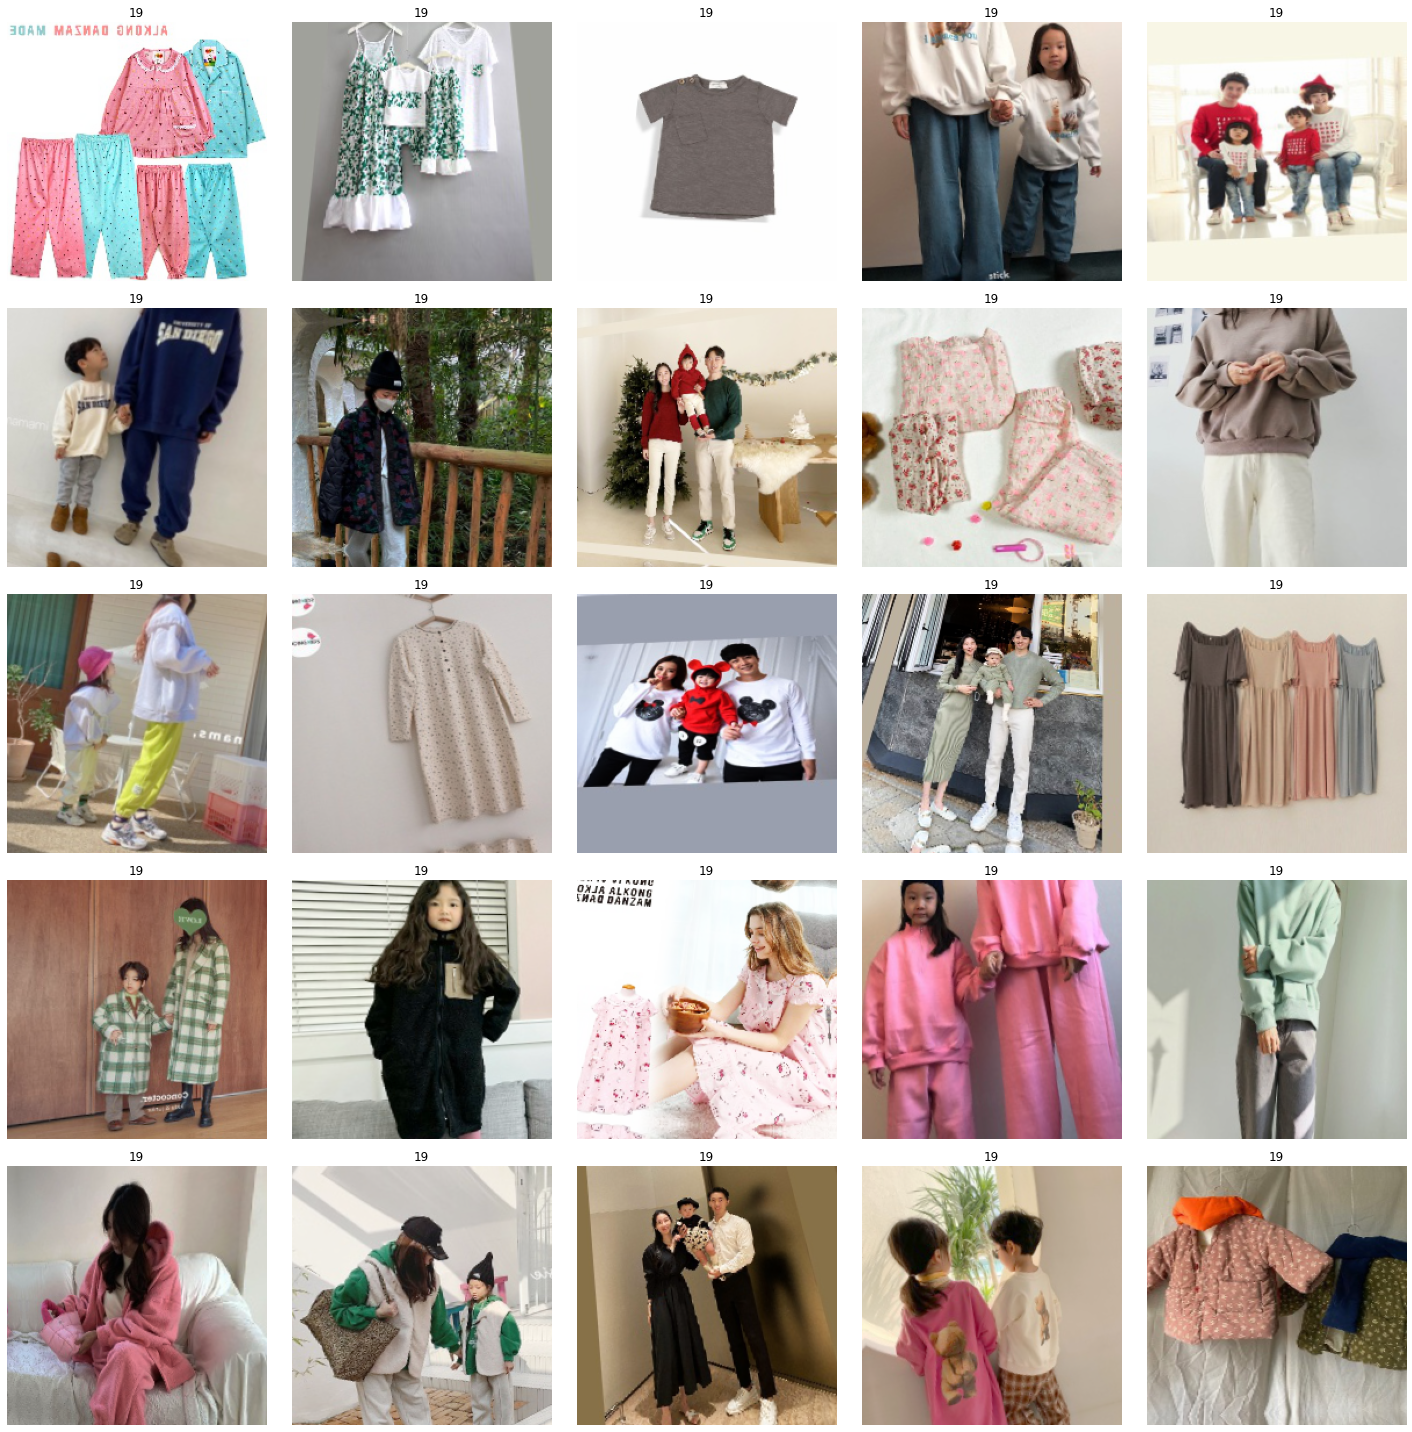

In [13]:
data.show_batch()

In [14]:
data

ImageDataBunch;

Train: LabelList (300 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
19,19,19,19,19
Path: /content/drive/MyDrive/네카라쿠배/딥러닝 프로젝트/dataset/fashion/padding_resize/train/2/19;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/MyDrive/네카라쿠배/딥러닝 프로젝트/dataset/fashion/padding_resize/train/2/19;

Test: LabelList (513 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/네카라쿠배/딥러닝 프로젝트/dataset/fashion/padding_resize/train/2/19

## ResNet50 pretrained model

In [15]:
torch.cuda.empty_cache()

gc.collect()

54981

In [16]:
from fastai.metrics import accuracy, top_k_accuracy

top_3_accuracy = partial(top_k_accuracy, k=3)
top_5_accuracy = partial(top_k_accuracy, k=5)

In [17]:
learner = cnn_learner(data, models.resnet152, metrics=[accuracy, top_3_accuracy, top_5_accuracy])
learner.model = torch.nn.DataParallel(learner.model)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [18]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time


RuntimeError: ignored

In [19]:
learner.fit_one_cycle(10, max_lr=1e-03)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time


RuntimeError: ignored

In [ ]:
# learner.save('resnet50-224-freezed')

In [ ]:
# .module because DataParallel was used
model = learner.model.module

## Get image feature vectors

In [ ]:
class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        "Applies `hook_func` to `module`, `input`, `output`."
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
        
def get_output(module, input_value, output):
    return output.flatten(1)

def get_input(module, input_value, output):
    return list(input_value)[0]

def get_named_module_from_model(model, name):
    for n, m in model.named_modules():
        if n == name:
            return m
    return None

In [ ]:
linear_output_layer = get_named_module_from_model(model, '1.4')
linear_output_layer

In [ ]:
# getting all images in train
train_valid_images_df = data_df[data_df['dataset'] != 'test']
inference_data_source = (ImageList.from_df(df=train_valid_images_df, path=images_path, cols='images')
                    .split_none()
                    .label_from_df(cols='category')
              )

In [ ]:
inference_data = inference_data_source.transform(tmfs, size=224).databunch(bs=32).normalize(imagenet_stats)

In [ ]:
inference_dataloader = inference_data.train_dl.new(shuffle=False)

In [ ]:
import time
img_repr_map = {}

with Hook(linear_output_layer, get_output, True, True) as hook:
    start = time.time()
    for i, (xb, yb) in enumerate(inference_dataloader):
        bs = xb.shape[0]
        img_ids = inference_dataloader.items[i*bs: (i+1)*bs]
        result = model.eval()(xb)
        img_reprs = hook.stored.cpu().numpy()
        img_reprs = img_reprs.reshape(bs, -1)
        for img_id, img_repr in zip(img_ids, img_reprs):
            img_repr_map[img_id] = img_repr
        if(len(img_repr_map) % 12800 == 0):
            end = time.time()
            print(f'{end-start} secs for 12800 images')
            start = end

In [ ]:
img_repr_df = pd.DataFrame(img_repr_map.items(), columns=['img_id', 'img_repr'])

In [ ]:
img_repr_df.shape

In [ ]:
img_repr_df['label'] = [inference_data.classes[x] for x in inference_data.train_ds.y.items[0:img_repr_df.shape[0]]]

In [ ]:
img_repr_df['label_id'] = inference_data.train_ds.y.items[0:img_repr_df.shape[0]]

## Getting similar images with cosine distance

In [ ]:
from scipy.spatial.distance import cosine

def get_similar_images(img_index, n=10):
    start = time.time()
    base_img_id, base_vector, base_label  = img_repr_df.iloc[img_index, [0, 1, 2]]
    cosine_similarity = 1 - img_repr_df['img_repr'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f'{end - start} secs')
    return base_img_id, base_label, img_repr_df.iloc[similar_img_ids]

def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_id']]
    categories = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys(images, categories)

In [ ]:
base_image, base_label, similar_images_df = get_similar_images(30000)

In [ ]:
print(base_label)
print(base_image)
open_image(base_image)

In [ ]:
show_similar_images(similar_images_df)

## TSNE plot

In [ ]:
from sklearn.manifold import TSNE

img_repr_matrix = [list(x) for x in img_repr_df['img_repr'].values]
tsne = TSNE(n_components=3, verbose=10, init='pca', perplexity=30, n_iter=500, n_iter_without_progress=100)
tsne_results_3 = tsne.fit_transform(img_repr_matrix)

In [ ]:
img_repr_df['tsne1'] = tsne_results_3[:,0]
img_repr_df['tsne2'] = tsne_results_3[:,1]
img_repr_df['tsne3'] = tsne_results_3[:,2]

In [ ]:
img_repr_df.to_parquet('deepFashion_similar_images')

In [ ]:
import plotly_express as px
px.scatter_3d(img_repr_df, x='tsne1', y='tsne2', z='tsne3', color='label')

## Using Annoy - Approximate Nearest Neighbors Oh Yeah!

In [ ]:
from annoy import AnnoyIndex

In [ ]:
f = len(img_repr_df['img_repr'][0])
t = AnnoyIndex(f, metric='euclidean')

In [ ]:
for i, vector in enumerate(img_repr_df['img_repr']):
    t.add_item(i, vector)
_  = t.build(inference_data.c)

In [ ]:
def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = img_repr_df.iloc[img_index, [0, 1, 2]]
    similar_img_ids = t.get_nns_by_item(img_index, 13)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    return base_img_id, base_label, img_repr_df.iloc[similar_img_ids[1:]]

In [ ]:
# 230000, 130000, 190000
base_image, base_label, similar_images_df = get_similar_images_annoy(149999)

In [ ]:
print(base_label)
open_image(base_image)

In [ ]:
similar_images_df

In [ ]:
show_similar_images(similar_images_df)